In [2]:
import pandas as pd
# In Colab, just use the filename if you uploaded it directly
path = 'Samut_Prakan.txt'

df = pd.read_csv(path, sep='\s+', skiprows=10, header=None, engine='python')
df = df[[0, 1, 2, 4]]
df.columns = ['Year', 'Month', 'Day', 'PM25']

print("Raw Data Loaded:")
print(df.head())

# ---------------------------------------------------------
# Clean and Prepare for Time Series
# ---------------------------------------------------------

# 1. Create a proper Date column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])

# 2. Set Date as index
df.set_index('Date', inplace=True)

# 3. Keep only the PM25 column
df = df[['PM25']]

print("\nCleaned DataFrame (Ready for LSTM):")
print(df.head())
print("\nData Info:")
print(df.info())

Raw Data Loaded:
   Year  Month  Day  PM25
0  2016      3    3  55.1
1  2016      3    3  55.1
2  2016      3    3  54.3
3  2016      3    3  54.3
4  2016      3    3  46.6

Cleaned DataFrame (Ready for LSTM):
            PM25
Date            
2016-03-03  55.1
2016-03-03  55.1
2016-03-03  54.3
2016-03-03  54.3
2016-03-03  46.6

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30313 entries, 2016-03-03 to 2020-01-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM25    30313 non-null  float64
dtypes: float64(1)
memory usage: 473.6 KB
None


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3475050883.py:5: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path, sep='\s+', skiprows=10, header=None, engine='python')


Daily Data Shape: (1334, 1)
                 PM25
Date                 
2016-03-03  44.300000
2016-03-04  30.637500
2016-03-05  26.116667
2016-03-06  26.487500
2016-03-07  28.204167


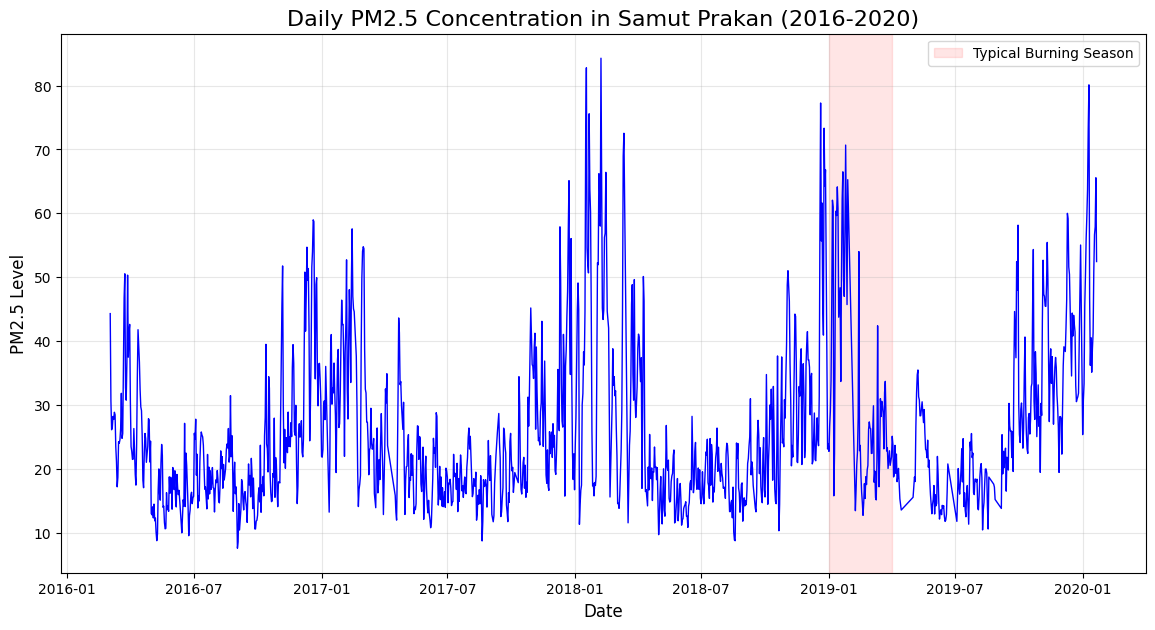

In [3]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Resample to Daily Average
# ---------------------------------------------------------
# 'D' stands for Daily. We calculate the mean PM2.5 for each day.
df_daily = df.resample('D').mean()

# Check for any missing days (just in case a whole day was missing)
df_daily = df_daily.dropna()

print("Daily Data Shape:", df_daily.shape)
print(df_daily.head())

# ---------------------------------------------------------
# Visualization (The "Seasonality" Graph)
# ---------------------------------------------------------
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['PM25'], color='blue', linewidth=1)

plt.title('Daily PM2.5 Concentration in Samut Prakan (2016-2020)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Level', fontsize=12)
plt.grid(True, alpha=0.3)

# Highlight the "Burning Season" (Approx Jan - Apr)
# This helps visually prove to the professor that you understand the data
plt.axvspan('2019-01', '2019-04', color='red', alpha=0.1, label='Typical Burning Season')

plt.legend()
plt.show()

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 1. Scale the Data (LSTMs work best with data between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_daily)

# 2. Create Sequences
# We will use the past 60 days to predict the next day.
look_back = 60
X, y = [], []

for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:i+look_back, 0])
    y.append(scaled_data[i+look_back, 0])

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# 3. Reshape for LSTM
# LSTM input shape: (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"Input Shape: {X.shape}") # Should be (Samples, 60, 1)

# 4. Split into Train and Test sets (80% Train, 20% Test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Input Shape: (1274, 60, 1)
Training samples: 1019
Testing samples: 255


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 1. Build the Model
model = Sequential()

# First LSTM layer (return_sequences=True because we are stacking layers)
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Dropout helps prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# The Output Layer (Prediction of the next day's PM2.5)
model.add(Dense(units=1))

# 2. Compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')

# 3. Train the Model
# We fit the model to our training data.
print("Starting training... (This might take a minute or two)")
history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

print("Training Complete!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Starting training... (This might take a minute or two)
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0323
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162
Epoch 6/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0156
Epoch 7/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0182
Epoch 8/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0149
Epoch 9/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150
Epoch 10/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0151
Epoch 11/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0146
Epoch 12/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118
Epoch 13/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0136
Epoch 14/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141
Epoch 15/25
32/32 ━━━━━━━━━━━

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


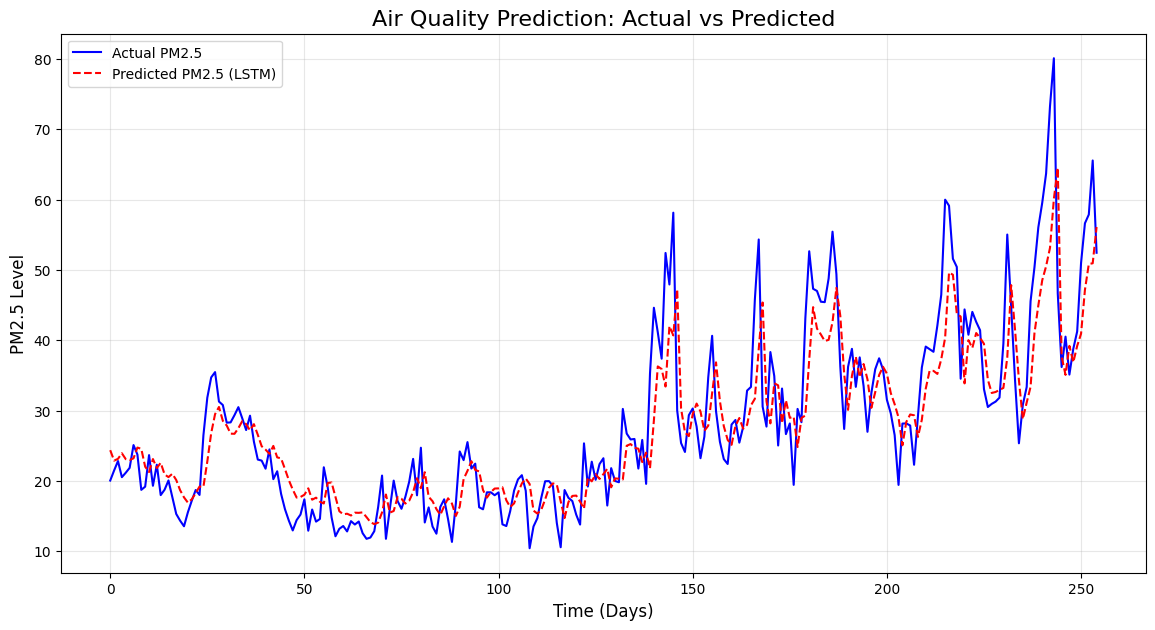

In [6]:
import matplotlib.pyplot as plt

# 1. Predict using the test data
predictions = model.predict(X_test)

# 2. Inverse Transform the predictions to get back to real PM2.5 numbers
# (Remember we scaled them to 0-1 earlier, now we scale back)
predictions = scaler.inverse_transform(predictions)

# 3. Inverse Transform the actual test data (y_test)
# y_test is currently a flat list (samples,), we need to reshape it to (samples, 1)
y_test_reshaped = y_test.reshape(-1, 1)
actual_pm25 = scaler.inverse_transform(y_test_reshaped)

# 4. Visualize the Results
plt.figure(figsize=(14, 7))

# Plot the Actual Values (Real data)
plt.plot(actual_pm25, color='blue', label='Actual PM2.5')

# Plot the Predicted Values (AI data)
plt.plot(predictions, color='red', linestyle='--', label='Predicted PM2.5 (LSTM)')

plt.title('Air Quality Prediction: Actual vs Predicted', fontsize=16)
plt.xlabel('Time (Days)', fontsize=12)
plt.ylabel('PM2.5 Level', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

In [7]:
# We need the last 60 days from the original dataset to start the prediction chain
last_60_days_data = scaled_data[-look_back:]

# Reshape it for the model: (1, 60, 1)
x_input = last_60_days_data.reshape(1, look_back, 1)

# List to store the predictions
temp_input = list(x_input)
lst_output = []

# Forecast the next 30 days
next_days = 30
i = 0

print("Forecasting the next 30 days...")

while(i < next_days):
    if(len(temp_input) > look_back):
        # Remove the first day, add the predicted day at the end (Sliding Window)
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape(1, look_back, 1)

        # Predict
        yhat = model.predict(x_input, verbose=0)

        # Store prediction
        temp_input.append(yhat[0][0])
        temp_input = temp_input[1:]
        lst_output.append(yhat[0][0])
        i = i + 1
    else:
        # Initial step
        x_input = x_input.reshape(1, look_back, 1)
        yhat = model.predict(x_input, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i = i + 1

# Inverse transform to get real PM2.5 values
future_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

print(future_predictions[:5]) # Show first 5 predicted days

Forecasting the next 30 days...
[[45.54009]
 [45.54009]
 [45.54009]
 [45.54009]
 [45.54009]]


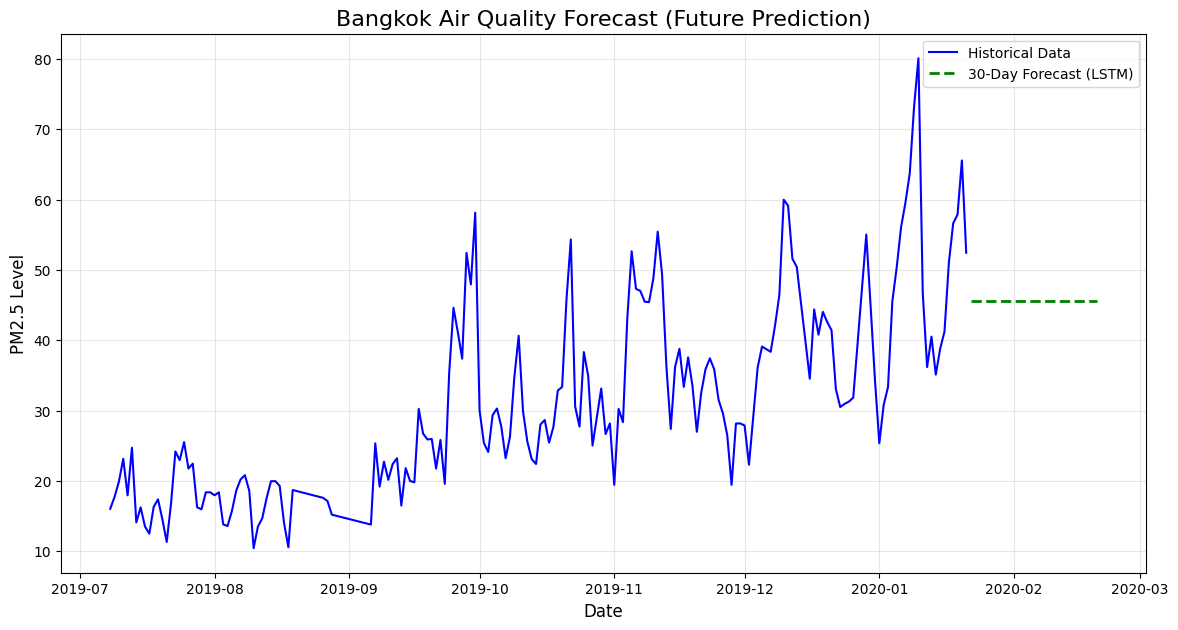

In [8]:
# 1. Generate future dates for the x-axis
last_date = df_daily.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=next_days, freq='D')

# 2. Create a DataFrame for the forecast
forecast_df = pd.DataFrame(future_predictions, index=future_dates, columns=['PM25'])

# 3. Plot Historical + Forecast
plt.figure(figsize=(14, 7))

# Plot the historical data (Last 6 months)
plt.plot(df_daily.index[-180:], df_daily['PM25'][-180:], color='blue', label='Historical Data')

# Plot the Forecast
plt.plot(forecast_df.index, forecast_df['PM25'], color='green', linestyle='--', linewidth=2, label='30-Day Forecast (LSTM)')

plt.title('Bangkok Air Quality Forecast (Future Prediction)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Level', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()